# Assignment Email

This email was received from David Meltzer on July 6, 2023 at 8:59AM PST. I began work at 6:00PM that day.

> Hi Russell,
>
> As I mentioned last week, the challenge is the last step in our interview process.  I have provided the instructions below, but if you need any clarification or have problems with how we have defined this, please let us know.  To the extent you incur any AWS costs as part of this, we will reimburse you.  There is no fixed deadline for this, but we are hoping to have it back within the next week or so to be able to make a decision.
>
> ----
>
> Use the IOT intrusion detection dataset for a supervised anomaly detection task. The label column indicates whether each row's data is normal or anomalous.
You can choose an ML classifier for training on this dataset.
>
> The task is to build a classifier using the train dataset and deploy a trained model in Sagemaker.
You can use your personal AWS account to do this.
The classifier should be able to generate robust classification metrics on a held-out test/validation dataset. You can use a portion of your train set for validation metrics.
>
> As for output, please send us a link to the code and classification results in your git repository when you are done. Configuration should be through an orchestration system so we can re-create the environment programmatically.
>
> We will use a held-out test set to evaluate your model's performance.
>
> Test data can be found here: [https://github.com/netography/ml-engineer/archive/refs/heads/main.zip](https://github.com/netography/ml-engineer/archive/refs/heads/main.zip)
>
> It can also be found here: [https://www.dropbox.com/scl/fi/oz1fspqu4mago3wxeb9dp/IoT-network-intrustion-dataset-train.csv?rlkey=d6hblxlw4t163tt386w16gldi&dl=0](https://www.dropbox.com/scl/fi/oz1fspqu4mago3wxeb9dp/IoT-network-intrustion-dataset-train.csv?rlkey=d6hblxlw4t163tt386w16gldi&dl=0)
>
> -Dave

In [1]:
import pandas as pd

pd.set_option('display.max_columns', 100)

# Load and Evaluate the Flow Logs

In [2]:
train_df = pd.read_parquet("data/ml-engineer-main/iot_network_intrustion_dataset_train.parquet")
train_df = train_df.rename(columns={"Unnamed: 0": "ID"})

train_df.head()

,ID,Flow_ID,Src_IP,Src_Port,Dst_IP,Dst_Port,Protocol,Timestamp,Flow_Duration,Tot_Fwd_Pkts,Tot_Bwd_Pkts,TotLen_Fwd_Pkts,TotLen_Bwd_Pkts,Fwd_Pkt_Len_Max,Fwd_Pkt_Len_Min,Fwd_Pkt_Len_Mean,Fwd_Pkt_Len_Std,Bwd_Pkt_Len_Max,Bwd_Pkt_Len_Min,Bwd_Pkt_Len_Mean,Bwd_Pkt_Len_Std,Flow_Byts/s,Flow_Pkts/s,Flow_IAT_Mean,Flow_IAT_Std,Flow_IAT_Max,Flow_IAT_Min,Fwd_IAT_Tot,Fwd_IAT_Mean,Fwd_IAT_Std,Fwd_IAT_Max,Fwd_IAT_Min,Bwd_IAT_Tot,Bwd_IAT_Mean,Bwd_IAT_Std,Bwd_IAT_Max,Bwd_IAT_Min,Fwd_PSH_Flags,Bwd_PSH_Flags,Fwd_URG_Flags,Bwd_URG_Flags,Fwd_Header_Len,Bwd_Header_Len,Fwd_Pkts/s,Bwd_Pkts/s,Pkt_Len_Min,Pkt_Len_Max,Pkt_Len_Mean,Pkt_Len_Std,Pkt_Len_Var,FIN_Flag_Cnt,SYN_Flag_Cnt,RST_Flag_Cnt,PSH_Flag_Cnt,ACK_Flag_Cnt,URG_Flag_Cnt,CWE_Flag_Count,ECE_Flag_Cnt,Down/Up_Ratio,Pkt_Size_Avg,Fwd_Seg_Size_Avg,Bwd_Seg_Size_Avg,Fwd_Byts/b_Avg,Fwd_Pkts/b_Avg,Fwd_Blk_Rate_Avg,Bwd_Byts/b_Avg,Bwd_Pkts/b_Avg,Bwd_Blk_Rate_Avg,Subflow_Fwd_Pkts,Subflow_Fwd_Byts,Subflow_Bwd_Pkts,Subflow_Bwd_Byts,Init_Fwd_Win_Byts,Init_Bwd_Win_Byts,Fwd_Act_Data_Pkts,Fwd_Seg_Size_Min,Active_Mean,Active_Std,Active_Max,Active_Min,Idle_Mean,Idle_Std,Idle_Max,Idle_Min,Label,Cat,Sub_Cat
0,315192,192.168.0.13-192.168.0.16-56361-10101-17,192.168.0.13,56361,192.168.0.16,10101,17,25/07/2019 03:23:29 AM,115,1,1,402.0,1430.0,402.0,402.0,402.0,0.000000,1430.0,1430.0,1430.0,0.000000,1.593043e+07,17391.304348,115.0,0.000000,115.0,115.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0,0,0,0,8,8,8695.652174,8695.652174,402.0,1430.0,1087.333333,593.516077,352261.333333,0,0,0,0,0,0,0,0,1.0,1631.000000,402.0,1430.0,0,0,0,0,0,0,1,402,1,1430,-1,-1,1,0,0.0,0.0,0.0,0.0,115.0,0.000000,115.0,115.0,Anomaly,Mirai,Mirai-Ackflooding
1,104915,192.168.0.24-222.239.240.107-57678-443-6,192.168.0.24,57678,222.239.240.107,443,6,20/05/2019 05:00:15 AM,259,0,3,0.0,4344.0,0.0,0.0,0.0,0.000000,1448.0,1448.0,1448.0,0.000000,1.677220e+07,11583.011583,129.5,12.020815,138.0,121.0,0.0,0.0,0.0,0.0,0.0,259.0,129.5,12.020815,138.0,121.0,0,0,0,0,0,96,0.000000,11583.011583,1448.0,1448.0,1448.000000,0.000000,0.000000,0,0,0,0,1,0,0,0,0.0,1930.666667,0.0,1448.0,0,0,0,0,0,0,0,0,3,4344,-1,139,0,0,0.0,0.0,0.0,0.0,129.5,12.020815,138.0,121.0,Normal,Normal,Normal
2,363451,192.168.0.13-192.168.0.16-9020-56266-6,192.168.0.16,56266,192.168.0.13,9020,6,10/09/2019 01:47:48 AM,123,0,2,0.0,1418.0,0.0,0.0,0.0,0.000000,1388.0,30.0,709.0,960.251009,1.152846e+07,16260.162602,123.0,0.000000,123.0,123.0,0.0,0.0,0.0,0.0,0.0,123.0,123.0,0.000000,123.0,123.0,0,0,0,0,0,64,0.000000,16260.162602,30.0,1388.0,935.333333,784.041666,614721.333333,0,0,0,0,1,0,0,0,0.0,1403.000000,0.0,709.0,0,0,0,0,0,0,0,0,2,1418,-1,1869,0,0,0.0,0.0,0.0,0.0,123.0,0.000000,123.0,123.0,Anomaly,Mirai,Mirai-Hostbruteforceg
3,477181,192.168.0.13-192.168.0.16-9020-52704-6,192.168.0.16,52704,192.168.0.13,9020,6,11/07/2019 01:12:32 AM,148,0,2,0.0,2776.0,0.0,0.0,0.0,0.000000,1388.0,1388.0,1388.0,0.000000,1.875676e+07,13513.513514,148.0,0.000000,148.0,148.0,0.0,0.0,0.0,0.0,0.0,148.0,148.0,0.000000,148.0,148.0,0,0,0,0,0,64,0.000000,13513.513514,1388.0,1388.0,1388.000000,0.000000,0.000000,0,0,0,0,1,0,0,0,0.0,2082.000000,0.0,1388.0,0,0,0,0,0,0,0,0,2,2776,-1,1869,0,0,0.0,0.0,0.0,0.0,148.0,0.000000,148.0,148.0,Anomaly,Scan,Scan Hostport
4,606027,192.168.0.13-192.168.0.16-10000-10101-17,192.168.0.13,10000,192.168.0.16,10101,17,25/07/2019 03:25:28 AM,282,2,1,1904.0,1430.0,1430.0,474.0,952.0,675.994083,1430.0,1430.0,1430.0,0.000000,1.182270e+07,10638.297872,141.0,70.710678,191.0,91.0,191.0,191.0,0.0,191.0,191.0,0.0,0.0,0.000000,0.0,0.0,0,0,0,0,16,8,7092.198582,3546.099291,474.0,1430.0,1191.000000,478.000000,228484.000000,0,0,0,0,0,0,0,0,0.0,1588.000000,952.0,1430.0,0,0,0,0,0,0,2,1904,1,1430,-1,-1,2,0,0.0,0.0,0.0,0.0,141.0,70.710678,191.0,91.0,Anomaly,Mirai,Mirai-Ackflooding


In [3]:
train_df.describe()

,ID,Src_Port,Dst_Port,Protocol,Flow_Duration,Tot_Fwd_Pkts,Tot_Bwd_Pkts,TotLen_Fwd_Pkts,TotLen_Bwd_Pkts,Fwd_Pkt_Len_Max,Fwd_Pkt_Len_Min,Fwd_Pkt_Len_Mean,Fwd_Pkt_Len_Std,Bwd_Pkt_Len_Max,Bwd_Pkt_Len_Min,Bwd_Pkt_Len_Mean,Bwd_Pkt_Len_Std,Flow_Byts/s,Flow_Pkts/s,Flow_IAT_Mean,Flow_IAT_Std,Flow_IAT_Max,Flow_IAT_Min,Fwd_IAT_Tot,Fwd_IAT_Mean,Fwd_IAT_Std,Fwd_IAT_Max,Fwd_IAT_Min,Bwd_IAT_Tot,Bwd_IAT_Mean,Bwd_IAT_Std,Bwd_IAT_Max,Bwd_IAT_Min,Fwd_PSH_Flags,Bwd_PSH_Flags,Fwd_URG_Flags,Bwd_URG_Flags,Fwd_Header_Len,Bwd_Header_Len,Fwd_Pkts/s,Bwd_Pkts/s,Pkt_Len_Min,Pkt_Len_Max,Pkt_Len_Mean,Pkt_Len_Std,Pkt_Len_Var,FIN_Flag_Cnt,SYN_Flag_Cnt,RST_Flag_Cnt,PSH_Flag_Cnt,ACK_Flag_Cnt,URG_Flag_Cnt,CWE_Flag_Count,ECE_Flag_Cnt,Down/Up_Ratio,Pkt_Size_Avg,Fwd_Seg_Size_Avg,Bwd_Seg_Size_Avg,Fwd_Byts/b_Avg,Fwd_Pkts/b_Avg,Fwd_Blk_Rate_Avg,Bwd_Byts/b_Avg,Bwd_Pkts/b_Avg,Bwd_Blk_Rate_Avg,Subflow_Fwd_Pkts,Subflow_Fwd_Byts,Subflow_Bwd_Pkts,Subflow_Bwd_Byts,Init_Fwd_Win_Byts,Init_Bwd_Win_Byts,Fwd_Act_Data_Pkts,Fwd_Seg_Size_Min,Active_Mean,Active_Std,Active_Max,Active_Min,Idle_Mean,Idle_Std,Idle_Max,Idle_Min
count,500626.000000,500626.000000,500626.000000,500626.000000,500626.000000,500626.000000,500626.000000,500626.000000,500626.000000,500626.000000,500626.000000,500626.000000,500626.000000,500626.000000,500626.000000,500626.000000,500626.000000,5.006260e+05,5.006260e+05,500626.000000,500626.000000,500626.000000,500626.000000,500626.000000,500626.000000,500626.000000,500626.000000,500626.000000,500626.000000,500626.000000,500626.000000,500626.000000,500626.000000,500626.0,500626.000000,500626.0,500626.000000,500626.000000,500626.000000,5.006260e+05,500626.000000,500626.000000,500626.000000,500626.000000,500626.000000,500626.000000,500626.000000,500626.000000,500626.000000,500626.000000,500626.000000,500626.000000,500626.000000,500626.000000,500626.000000,500626.000000,500626.000000,500626.000000,500626.0,500626.0,500626.0,500626.0,500626.0,500626.0,500626.000000,500626.000000,500626.000000,500626.000000,500626.0,500626.000000,500626.000000,500626.0,500626.000000,500626.000000,500626.000000,500626.000000,500626.000000,500626.000000,500626.000000,500626.000000
mean,313032.637084,35045.114962,16392.202506,9.970825,631.768646,1.676425,1.466394,569.632550,926.820031,392.079391,347.845919,373.187747,28.075772,681.141894,588.476344,636.863302,62.921255,inf,inf,482.905193,61.509933,563.190258,443.545141,100.019328,51.632779,27.166793,83.542904,34.131927,513.962859,445.891003,28.053083,484.683185,428.262901,0.0,0.026593,0.0,0.000056,22.478385,33.657996,5.046282e+04,27842.365842,511.434160,699.787768,633.339985,102.517288,69649.683424,0.000539,0.092724,0.000511,0.026593,0.530674,0.000056,0.000216,0.000068,0.364939,914.822026,373.187747,636.863302,0.0,0.0,0.0,0.0,0.0,0.0,1.676425,569.632550,1.466394,926.820031,-1.0,5886.377595,1.511318,0.0,3.678091,0.322559,4.087922,3.399306,501.095183,51.108721,558.971126,466.819931
std,180633.665830,24718.622926,17554.442272,5.380044,3455.950187,4.316453,0.904491,1143.744636,1314.801566,619.338077,587.993156,596.359647,144.160947,694.984157,682.867792,669.554267,227.584442,NaN,NaN,1898.921239,1129.725193,2835.568432,1733.844124,2172.224490,1193.921341,939.169121,1904.676273,987.380186,3112.799071,2234.546802,786.182321,2727.857064,2173.809583,0.0,0.160890,0.0,0.007478,40.852942,30.598958,1.649464e+05,78491.927333,653.887171,696.823235,652.269622,243.187185,179117.562307,0.023217,0.290045,0.022608,0.160890,0.499059,0.007478,0.014686,0.008241,0.499165,948.684981,596.359647,669.554267,0.0,0.0,0.0,0.0,0.0,0.0,4.316453,1143.744636,0.904491,1314.801566,0.0,11540.560492,4.341830,0.0,66.708160,16.269218,78.070821,63.866128,2105.975309,1120.897418,2835.755260,1934.422976
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,2.000540e+01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0

In [4]:
print(f"{len(train_df):,}")

500,626


In [5]:
test_df = pd.read_parquet("data/ml-engineer-main/iot_network_intrustion_dataset_test.parquet")
test_df = test_df.rename(columns={"Unnamed: 0": "ID"})

test_df.head()

,ID,Flow_ID,Src_IP,Src_Port,Dst_IP,Dst_Port,Protocol,Timestamp,Flow_Duration,Tot_Fwd_Pkts,Tot_Bwd_Pkts,TotLen_Fwd_Pkts,TotLen_Bwd_Pkts,Fwd_Pkt_Len_Max,Fwd_Pkt_Len_Min,Fwd_Pkt_Len_Mean,Fwd_Pkt_Len_Std,Bwd_Pkt_Len_Max,Bwd_Pkt_Len_Min,Bwd_Pkt_Len_Mean,Bwd_Pkt_Len_Std,Flow_Byts/s,Flow_Pkts/s,Flow_IAT_Mean,Flow_IAT_Std,Flow_IAT_Max,Flow_IAT_Min,Fwd_IAT_Tot,Fwd_IAT_Mean,Fwd_IAT_Std,Fwd_IAT_Max,Fwd_IAT_Min,Bwd_IAT_Tot,Bwd_IAT_Mean,Bwd_IAT_Std,Bwd_IAT_Max,Bwd_IAT_Min,Fwd_PSH_Flags,Bwd_PSH_Flags,Fwd_URG_Flags,Bwd_URG_Flags,Fwd_Header_Len,Bwd_Header_Len,Fwd_Pkts/s,Bwd_Pkts/s,Pkt_Len_Min,Pkt_Len_Max,Pkt_Len_Mean,Pkt_Len_Std,Pkt_Len_Var,FIN_Flag_Cnt,SYN_Flag_Cnt,RST_Flag_Cnt,PSH_Flag_Cnt,ACK_Flag_Cnt,URG_Flag_Cnt,CWE_Flag_Count,ECE_Flag_Cnt,Down/Up_Ratio,Pkt_Size_Avg,Fwd_Seg_Size_Avg,Bwd_Seg_Size_Avg,Fwd_Byts/b_Avg,Fwd_Pkts/b_Avg,Fwd_Blk_Rate_Avg,Bwd_Byts/b_Avg,Bwd_Pkts/b_Avg,Bwd_Blk_Rate_Avg,Subflow_Fwd_Pkts,Subflow_Fwd_Byts,Subflow_Bwd_Pkts,Subflow_Bwd_Byts,Init_Fwd_Win_Byts,Init_Bwd_Win_Byts,Fwd_Act_Data_Pkts,Fwd_Seg_Size_Min,Active_Mean,Active_Std,Active_Max,Active_Min,Idle_Mean,Idle_Std,Idle_Max,Idle_Min,Label,Cat,Sub_Cat
0,230773,163.152.127.193-192.168.0.13-10101-56361-17,192.168.0.13,56361,163.152.127.193,10101,17,20/08/2019 03:05:41 AM,141,2,1,1450.0,20.0,1430.0,20.0,725.0,997.020561,20.0,20.0,20.0,0.0,1.042553e+07,2.127660e+04,70.5,2.121320,72.0,69.0,69.0,69.0,0.0,69.0,69.0,0.0,0.0,0.000000,0.0,0.0,0,0,0,0,16,8,14184.397163,7092.198582,20.0,1430.0,372.5,705.0,497025.0,0,0,0,0,0,0,0,0,0.0,496.666667,725.0,20.0,0,0,0,0,0,0,2,1450,1,20,-1,-1,2,0,0.0,0.0,0.0,0.0,70.5,2.121320,72.0,69.0,Anomaly,Mirai,Mirai-Hostbruteforceg
1,521223,192.168.0.24-210.89.164.90-64776-9988-17,192.168.0.24,64776,210.89.164.90,9988,17,25/07/2019 03:20:13 AM,1,1,1,32.0,32.0,32.0,32.0,32.0,0.000000,32.0,32.0,32.0,0.0,6.400000e+07,2.000000e+06,1.0,0.000000,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0,0,0,0,8,8,1000000.000000,1000000.000000,32.0,32.0,32.0,0.0,0.0,0,0,0,0,0,0,0,0,1.0,48.000000,32.0,32.0,0,0,0,0,0,0,1,32,1,32,-1,-1,1,0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,Anomaly,Mirai,Mirai-UDP Flooding
2,155309,192.168.0.13-192.168.0.16-9020-49784-6,192.168.0.13,9020,192.168.0.16,49784,6,20/05/2019 04:58:07 AM,482,0,5,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000e+00,1.037344e+04,120.5,96.334487,265.0,72.0,0.0,0.0,0.0,0.0,0.0,482.0,120.5,96.334487,265.0,72.0,0,0,0,0,0,160,0.000000,10373.443983,0.0,0.0,0.0,0.0,0.0,0,0,0,0,1,0,0,0,0.0,0.000000,0.0,0.0,0,0,0,0,0,0,0,0,5,0,-1,32505,0,0,0.0,0.0,0.0,0.0,120.5,96.334487,265.0,72.0,Normal,Normal,Normal
3,42560,192.168.0.24-104.118.134.215-43238-443-6,104.118.134.215,443,192.168.0.24,43238,6,25/07/2019 03:21:48 AM,269,1,1,1441.0,1441.0,1441.0,1441.0,1441.0,0.000000,1441.0,1441.0,1441.0,0.0,1.071375e+07,7.434944e+03,269.0,0.000000,269.0,269.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0,0,0,0,32,32,3717.472119,3717.472119,1441.0,1441.0,1441.0,0.0,0.0,0,0,0,0,1,0,0,0,1.0,2161.500000,1441.0,1441.0,0,0,0,0,0,0,1,1441,1,1441,-1,252,1,0,0.0,0.0,0.0,0.0,269.0,0.000000,269.0,269.0,Anomaly,Mirai,Mirai-Ackflooding
4,326612,192.168.0.13-192.168.0.16-9020-52727-6,192.168.0.16,52727,192.168.0.13,9020,6,11/07/2019 01:24:03 AM,73,0,2,0.0,2776.0,0.0,0.0,0.0,0.000000,1388.0,1388.0,1388.0,0.0,3.802740e+07,2.739726e+04,73.0,0.000000,73.0,73.0,0.0,0.0,0.0,0.0,0.0,73.0,73.0,0.000000,73.0,73.0,0,0,0,0,0,64,0.000000,27397.260274,1388.0,1388.0,1388.0,0.0,0.0,0,0,0,0,1,0,0,0,0.0,2082.000000,0.0,1388.0,0,0,0,0,0,0,0,0,2,2776,-1,1869,0,0,0.0,0.0,0.0,0.0,73.0,0.000000,73.0,73.0,Anomaly,Scan,Scan Port OS


In [6]:
test_df.describe()

,ID,Src_Port,Dst_Port,Protocol,Flow_Duration,Tot_Fwd_Pkts,Tot_Bwd_Pkts,TotLen_Fwd_Pkts,TotLen_Bwd_Pkts,Fwd_Pkt_Len_Max,Fwd_Pkt_Len_Min,Fwd_Pkt_Len_Mean,Fwd_Pkt_Len_Std,Bwd_Pkt_Len_Max,Bwd_Pkt_Len_Min,Bwd_Pkt_Len_Mean,Bwd_Pkt_Len_Std,Flow_Byts/s,Flow_Pkts/s,Flow_IAT_Mean,Flow_IAT_Std,Flow_IAT_Max,Flow_IAT_Min,Fwd_IAT_Tot,Fwd_IAT_Mean,Fwd_IAT_Std,Fwd_IAT_Max,Fwd_IAT_Min,Bwd_IAT_Tot,Bwd_IAT_Mean,Bwd_IAT_Std,Bwd_IAT_Max,Bwd_IAT_Min,Fwd_PSH_Flags,Bwd_PSH_Flags,Fwd_URG_Flags,Bwd_URG_Flags,Fwd_Header_Len,Bwd_Header_Len,Fwd_Pkts/s,Bwd_Pkts/s,Pkt_Len_Min,Pkt_Len_Max,Pkt_Len_Mean,Pkt_Len_Std,Pkt_Len_Var,FIN_Flag_Cnt,SYN_Flag_Cnt,RST_Flag_Cnt,PSH_Flag_Cnt,ACK_Flag_Cnt,URG_Flag_Cnt,CWE_Flag_Count,ECE_Flag_Cnt,Down/Up_Ratio,Pkt_Size_Avg,Fwd_Seg_Size_Avg,Bwd_Seg_Size_Avg,Fwd_Byts/b_Avg,Fwd_Pkts/b_Avg,Fwd_Blk_Rate_Avg,Bwd_Byts/b_Avg,Bwd_Pkts/b_Avg,Bwd_Blk_Rate_Avg,Subflow_Fwd_Pkts,Subflow_Fwd_Byts,Subflow_Bwd_Pkts,Subflow_Bwd_Byts,Init_Fwd_Win_Byts,Init_Bwd_Win_Byts,Fwd_Act_Data_Pkts,Fwd_Seg_Size_Min,Active_Mean,Active_Std,Active_Max,Active_Min,Idle_Mean,Idle_Std,Idle_Max,Idle_Min
count,125157.000000,125157.000000,125157.000000,125157.000000,125157.000000,125157.000000,125157.000000,125157.000000,125157.000000,125157.000000,125157.000000,125157.000000,125157.000000,125157.000000,125157.000000,125157.000000,125157.000000,1.251570e+05,1.251570e+05,125157.000000,125157.000000,125157.000000,125157.000000,125157.000000,125157.000000,125157.000000,125157.000000,125157.000000,125157.000000,125157.000000,125157.000000,125157.000000,125157.000000,125157.0,125157.000000,125157.0,125157.000000,125157.000000,125157.000000,1.251570e+05,125157.000000,125157.000000,125157.000000,125157.000000,125157.000000,125157.000000,125157.000000,125157.000000,125157.000000,125157.000000,125157.000000,125157.000000,125157.000000,125157.000000,125157.000000,125157.000000,125157.000000,125157.000000,125157.0,125157.0,125157.0,125157.0,125157.0,125157.0,125157.000000,125157.000000,125157.000000,125157.000000,125157.0,125157.000000,125157.000000,125157.0,125157.000000,125157.000000,125157.000000,125157.000000,125157.000000,125157.000000,125157.000000,125157.000000
mean,312324.453926,34950.321404,16366.327453,9.973881,650.039686,1.672132,1.477073,575.164681,939.124699,394.131059,349.249175,375.032257,28.502382,682.555231,589.421311,638.083057,63.270811,inf,inf,485.691985,69.644639,576.339773,441.334636,110.712401,56.046393,29.779069,90.948920,36.868917,528.112235,451.258928,31.740977,494.791718,431.235472,0.0,0.025680,0.0,0.000032,22.538500,33.966075,4.968508e+04,27721.063378,512.491175,701.295069,634.974124,102.697929,69784.619603,0.000479,0.093834,0.000384,0.025680,0.529679,0.000032,0.000168,0.000064,0.363503,916.943221,375.032257,638.083057,0.0,0.0,0.0,0.0,0.0,0.0,1.672132,575.164681,1.477073,939.124699,-1.0,5859.113426,1.504295,0.0,4.109658,0.476690,4.891984,3.713568,508.138405,57.585072,571.818013,469.042563
std,180705.616965,24730.698084,17534.091479,5.379128,3655.330974,4.283955,2.040416,1231.716717,2842.547976,620.525868,588.837133,597.325066,145.134609,695.053098,683.225505,669.602542,228.528024,NaN,NaN,1868.432081,1272.601923,2986.174636,1660.025339,2384.478910,1281.777384,1034.638107,2054.696724,1050.800571,3281.603134,2273.858913,892.983099,2846.363293,2193.845851,0.0,0.158179,0.0,0.005653,44.136902,66.095549,1.622552e+05,78439.864950,654.209225,696.922620,652.452694,243.389047,179223.794858,0.021890,0.291599,0.019580,0.158179,0.499120,0.005653,0.012952,0.007995,0.499108,948.658631,597.325066,669.602542,0.0,0.0,0.0,0.0,0.0,0.0,4.283955,1231.716717,2.040416,2842.547976,0.0,11485.788681,4.296188,0.0,73.238386,32.992821,123.149347,65.081136,2140.656964,1274.170555,2986.293031,1921.831800
min,16.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,2.177108e+01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000

In [7]:
print(f"{len(test_df):,}")

125,157


## How are flows unique?

In [8]:
print(f'{len(train_df["ID"].unique()):,}')

500,626


In [9]:
print(f'{len(train_df["Flow_ID"].unique()):,}')

51,873


In [10]:
print(f'{len(train_df[train_df.Flow_ID == "163.152.127.193-192.168.0.13-10101-56361-17"]):,}')

5,984


## This seems like it...

In [11]:
train_df[train_df.Flow_ID == "163.152.127.193-192.168.0.13-10101-56361-17"].sort_values(["Timestamp", "ID"])

,ID,Flow_ID,Src_IP,Src_Port,Dst_IP,Dst_Port,Protocol,Timestamp,Flow_Duration,Tot_Fwd_Pkts,Tot_Bwd_Pkts,TotLen_Fwd_Pkts,TotLen_Bwd_Pkts,Fwd_Pkt_Len_Max,Fwd_Pkt_Len_Min,Fwd_Pkt_Len_Mean,Fwd_Pkt_Len_Std,Bwd_Pkt_Len_Max,Bwd_Pkt_Len_Min,Bwd_Pkt_Len_Mean,Bwd_Pkt_Len_Std,Flow_Byts/s,Flow_Pkts/s,Flow_IAT_Mean,Flow_IAT_Std,Flow_IAT_Max,Flow_IAT_Min,Fwd_IAT_Tot,Fwd_IAT_Mean,Fwd_IAT_Std,Fwd_IAT_Max,Fwd_IAT_Min,Bwd_IAT_Tot,Bwd_IAT_Mean,Bwd_IAT_Std,Bwd_IAT_Max,Bwd_IAT_Min,Fwd_PSH_Flags,Bwd_PSH_Flags,Fwd_URG_Flags,Bwd_URG_Flags,Fwd_Header_Len,Bwd_Header_Len,Fwd_Pkts/s,Bwd_Pkts/s,Pkt_Len_Min,Pkt_Len_Max,Pkt_Len_Mean,Pkt_Len_Std,Pkt_Len_Var,FIN_Flag_Cnt,SYN_Flag_Cnt,RST_Flag_Cnt,PSH_Flag_Cnt,ACK_Flag_Cnt,URG_Flag_Cnt,CWE_Flag_Count,ECE_Flag_Cnt,Down/Up_Ratio,Pkt_Size_Avg,Fwd_Seg_Size_Avg,Bwd_Seg_Size_Avg,Fwd_Byts/b_Avg,Fwd_Pkts/b_Avg,Fwd_Blk_Rate_Avg,Bwd_Byts/b_Avg,Bwd_Pkts/b_Avg,Bwd_Blk_Rate_Avg,Subflow_Fwd_Pkts,Subflow_Fwd_Byts,Subflow_Bwd_Pkts,Subflow_Bwd_Byts,Init_Fwd_Win_Byts,Init_Bwd_Win_Byts,Fwd_Act_Data_Pkts,Fwd_Seg_Size_Min,Active_Mean,Active_Std,Active_Max,Active_Min,Idle_Mean,Idle_Std,Idle_Max,Idle_Min,Label,Cat,Sub_Cat
218993,71240,163.152.127.193-192.168.0.13-10101-56361-17,192.168.0.13,56361,163.152.127.193,10101,17,20/08/2019 03:03:06 AM,127,1,1,1430.0,1430.0,1430.0,1430.0,1430.0,0.0,1430.0,1430.0,1430.0,0.0,2.251969e+07,15748.031496,127.0,0.0,127.0,127.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,8,8,7874.015748,7874.015748,1430.0,1430.0,1430.000000,0.000000,0.000000,0,0,0,0,0,0,0,0,1.0,2145.0,1430.0,1430.0,0,0,0,0,0,0,1,1430,1,1430,-1,-1,1,0,0.0,0.0,0.0,0.0,127.0,0.0,127.0,127.0,Anomaly,Mirai,Mirai-Hostbruteforceg
483004,232004,163.152.127.193-192.168.0.13-10101-56361-17,192.168.0.13,56361,163.152.127.193,10101,17,20/08/2019 03:03:06 AM,168,1,1,1430.0,1430.0,1430.0,1430.0,1430.0,0.0,1430.0,1430.0,1430.0,0.0,1.702381e+07,11904.761905,168.0,0.0,168.0,168.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,8,8,5952.380952,5952.380952,1430.0,1430.0,1430.000000,0.000000,0.000000,0,0,0,0,0,0,0,0,1.0,2145.0,1430.0,1430.0,0,0,0,0,0,0,1,1430,1,1430,-1,-1,1,0,0.0,0.0,0.0,0.0,168.0,0.0,168.0,168.0,Anomaly,Mirai,Mirai-Hostbruteforceg
413738,343336,163.152.127.193-192.168.0.13-10101-56361-17,192.168.0.13,56361,163.152.127.193,10101,17,20/08/2019 03:03:06 AM,71,1,1,1430.0,1370.0,1430.0,1430.0,1430.0,0.0,1370.0,1370.0,1370.0,0.0,3.943662e+07,28169.014085,71.0,0.0,71.0,71.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,8,8,14084.507042,14084.507042,1370.0,1430.0,1390.000000,34.641016,1200.000000,0,0,0,0,0,0,0,0,1.0,2085.0,1430.0,1370.0,0,0,0,0,0,0,1,1430,1,1370,-1,-1,1,0,0.0,0.0,0.0,0.0,71.0,0.0,71.0,71.0,Anomaly,Mirai,Mirai-Hostbruteforceg
148233,371295,163.152.127.193-192.168.0.13-10101-56361-17,192.168.0.13,56361,163.152.127.193,10101,17,20/08/2019 03:03:06 AM,117,1,1,1430.0,1430.0,1430.0,1430.0,1430.0,0.0,1430.0,1430.0,1430.0,0.0,2.444444e+07,17094.017094,117.0,0.0,117.0,117.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,8,8,8547.008547,8547.008547,1430.0,1430.0,1430.000000,0.000000,0.000000,0,0,0,0,0,0,0,0,1.0,2145.0,1430.0,1430.0,0,0,0,0,0,0,1,1430,1,1430,-1,-1,1,0,0.0,0.0,0.0,0.0,117.0,0.0,117.0,117.0,Anomaly,Mirai,Mirai-Hostbruteforceg
344622,414818,163.152.127.193-192.168.0.13-10101-56361-17,192.168.0.13,56361,163.152.127.193,10101,17,20/08/2019 03:03:06 AM,121,1,1,1430.0,1430.0,1430.0,1430.0,1430.0,0.0,1430.0,1430.0,1430.0,0.0,2.363636e+07,16528.925620,121.0,0.0,121.0,121.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,8,8,8264.462810,8264.462810,1430.0,1430.0,1430.000000,0.000000,0.000000,0,0,0,0,0,0,0,0,1.0,2145.0,1430.0,1430.0,0,0,0,0,0,0,1,1430,1,1430,-1,-1,1,0,0.0,0.0,0.0,0.0,121.0,0.0,121.0,121.0,Anomaly,Mirai,Mirai-Hostbruteforceg
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,.

## Label Check

As we see below, the data is just 6.4% / 6.1% normal event types. I would like to ask a question about this, but at this late date I will go with what I can determine. 

In [180]:
train_label_counts = train_df["Label"].value_counts()

train_normal_pct = (train_label_counts[1] / train_label_counts.sum()) * 100
print(f"Normal label percentage: {train_normal_pct:,.2f}%\n")

train_label_counts

Normal label percentage: 6.43%



Anomaly    468446
Normal      32180
Name: Label, dtype: int64

In [181]:
test_label_counts = test_df["Label"].value_counts()

test_normal_pct = (test_label_counts[1] / test_label_counts.sum()) * 100
print(f"Normal label percentage: {test_normal_pct:,.2f}%\n")

test_label_counts

Normal label percentage: 6.31%



Anomaly    117264
Normal       7893
Name: Label, dtype: int64

### Discussion

We might assume the proportion isn't representative of the problem which means we might perform some sample that oversamples normal data. While I don't know how the data was sampled, I am going to assume it is a representative, random sample... it is the only prior I have evidence for at this time. The problem is thus flipped on its head. We need to detect normal traffic and throw out anomalies.

Perhaps this is a web server? Let's do some more EDA to understand it, so I can feel comfortable about proceeding.

In [14]:
[
    len(train_df["Src_IP"].unique()),
    len(train_df["Dst_IP"].unique()),
]

[46331, 460]

In [15]:
# How many IPs have more than 1 connection?
# ip_counts = train_df.groupby("Dst_IP").filter(lambda x: len(x) > 1)["Dst_IP"].value_counts()

ip_counts = train_df["Dst_IP"].value_counts()
ip_counts

192.168.0.13       131558
192.168.0.16       114589
210.89.164.90      105099
192.168.0.24        68540
222.239.240.107      9016
                    ...  
168.126.63.1            1
222.210.95.147          1
111.84.5.129            1
31.237.26.217           1
52.114.128.44           1
Name: Dst_IP, Length: 460, dtype: int64

<Axes: xlabel='Dst_IP', ylabel='Count'>

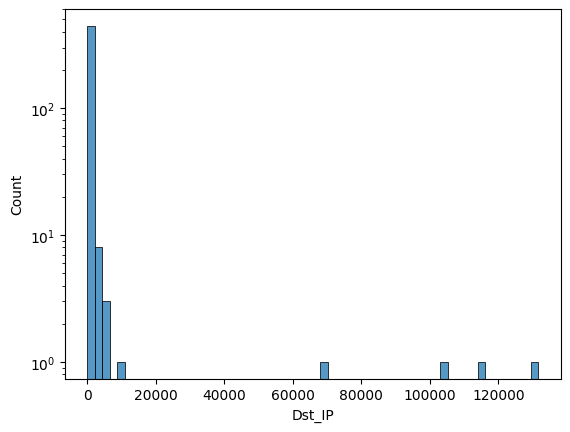

In [16]:
# Time for a histogram!
import seaborn as sns

sns.histplot(data=ip_counts, bins=60, log=True)

In [17]:
# Get a sense of the distribution across destination IPs
dst_label_counts = train_df[["Dst_IP", "Label"]].value_counts().reset_index().sort_values(by=["Dst_IP", "Label"], ascending=[True, False])
dlc_df = dst_label_counts[dst_label_counts["Dst_IP"].str.startswith("192.168.0")]
dlc_df

,Dst_IP,Label,0
346,192.168.0.1,Normal,4
58,192.168.0.1,Anomaly,239
11,192.168.0.13,Normal,3422
0,192.168.0.13,Anomaly,128136
20,192.168.0.14,Normal,1361
18,192.168.0.14,Anomaly,1599
70,192.168.0.15,Anomaly,175
4,192.168.0.16,Normal,25288
2,192.168.0.16,Anomaly,89301
67,192.168.0.23,Normal,195


In [18]:
ip_counts = train_df[["Dst_IP", "Label"]].value_counts().sort_index()
ip_counts = ip_counts.to_frame().rename(columns={0: "count"})
ip_counts

count
Dst_IP       Label         
0.0.0.16     Anomaly      2
             Normal       2
0.0.0.36     Anomaly     34
0.40.0.0     Anomaly      1
0.40.0.1     Anomaly      1
...                     ...
8.8.8.8      Anomaly      1
82.231.1.105 Normal       1
82.231.1.181 Anomaly      1
82.231.1.203 Anomaly      4
96.16.99.81  Anomaly    468

[485 rows x 1 columns]

In [19]:
ip_val_counts = ip_counts.reset_index().rename(columns={"count": "IP_Count"})
ip_val_counts

,Dst_IP,Label,IP_Count
0,0.0.0.16,Anomaly,2
1,0.0.0.16,Normal,2
2,0.0.0.36,Anomaly,34
3,0.40.0.0,Anomaly,1
4,0.40.0.1,Anomaly,1
...,...,...,...
480,8.8.8.8,Anomaly,1
481,82.231.1.105,Normal,1
482,82.231.1.181,Anomaly,1
483,82.231.1.203,Anomaly,4


### Comparing Anomaly / Label Rations per IP

The following histogram is interesting... there is no clear pattern visible in terms of label per destination IP. I am going to stop my EDA here and move on to a baseline unsupervised 

<Axes: xlabel='IP_Count', ylabel='Count'>

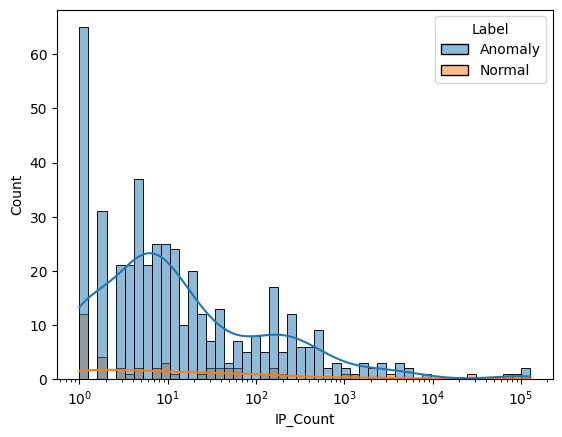

In [20]:
sns.histplot(data=ip_val_counts, x="IP_Count", hue="Label", kde=True, bins=50, log_scale=True)

## Network Visualization

I just have to look at this as a network before moving onto actual machine learning... as I just worked at Graphistry and am familiar with their tool.

### Preparing a Dataset to Visualize

I need to see the network before proceeding onwards because I tend to make fundamental errors when I don't perform this step... sort of like in this exercise - the work I did in CloudFormation to setup a new SageMaker notebook inside a VPC - when I could have just used a SageMaker domain and the SageMaker Python SDK to publish a model very easily. In any case... let's do a first pass visualization.

In [24]:
viz_df = train_df[["Flow_ID", "Src_IP", "Src_Port", "Dst_IP", "Dst_Port", "Timestamp", "Protocol", "Label"]]
viz_df.head()

,Flow_ID,Src_IP,Src_Port,Dst_IP,Dst_Port,Timestamp,Protocol,Label
0,192.168.0.13-192.168.0.16-56361-10101-17,192.168.0.13,56361,192.168.0.16,10101,25/07/2019 03:23:29 AM,17,Anomaly
1,192.168.0.24-222.239.240.107-57678-443-6,192.168.0.24,57678,222.239.240.107,443,20/05/2019 05:00:15 AM,6,Normal
2,192.168.0.13-192.168.0.16-9020-56266-6,192.168.0.16,56266,192.168.0.13,9020,10/09/2019 01:47:48 AM,6,Anomaly
3,192.168.0.13-192.168.0.16-9020-52704-6,192.168.0.16,52704,192.168.0.13,9020,11/07/2019 01:12:32 AM,6,Anomaly
4,192.168.0.13-192.168.0.16-10000-10101-17,192.168.0.13,10000,192.168.0.16,10101,25/07/2019 03:25:28 AM,17,Anomaly


In [25]:
viz_df["src"] = viz_df["Src_IP"] + " / " + viz_df["Src_Port"].astype("str") + " / " + viz_df["Protocol"].astype("str")
viz_df["dst"] = viz_df["Dst_IP"] + " / " + viz_df["Dst_Port"].astype("str") + " / " + viz_df["Protocol"].astype("str")

viz_df.head()

/tmp/ipykernel_94195/1514597115.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  viz_df["src"] = viz_df["Src_IP"] + " / " + viz_df["Src_Port"].astype("str") + " / " + viz_df["Protocol"].astype("str")
/tmp/ipykernel_94195/1514597115.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  viz_df["dst"] = viz_df["Dst_IP"] + " / " + viz_df["Dst_Port"].astype("str") + " / " + viz_df["Protocol"].astype("str")


,Flow_ID,Src_IP,Src_Port,Dst_IP,Dst_Port,Timestamp,Protocol,Label,src,dst
0,192.168.0.13-192.168.0.16-56361-10101-17,192.168.0.13,56361,192.168.0.16,10101,25/07/2019 03:23:29 AM,17,Anomaly,192.168.0.13 / 56361 / 17,192.168.0.16 / 10101 / 17
1,192.168.0.24-222.239.240.107-57678-443-6,192.168.0.24,57678,222.239.240.107,443,20/05/2019 05:00:15 AM,6,Normal,192.168.0.24 / 57678 / 6,222.239.240.107 / 443 / 6
2,192.168.0.13-192.168.0.16-9020-56266-6,192.168.0.16,56266,192.168.0.13,9020,10/09/2019 01:47:48 AM,6,Anomaly,192.168.0.16 / 56266 / 6,192.168.0.13 / 9020 / 6
3,192.168.0.13-192.168.0.16-9020-52704-6,192.168.0.16,52704,192.168.0.13,9020,11/07/2019 01:12:32 AM,6,Anomaly,192.168.0.16 / 52704 / 6,192.168.0.13 / 9020 / 6
4,192.168.0.13-192.168.0.16-10000-10101-17,192.168.0.13,10000,192.168.0.16,10101,25/07/2019 03:25:28 AM,17,Anomaly,192.168.0.13 / 10000 / 17,192.168.0.16 / 10101 / 17


### Are Flow IDs Labeled All or Nothing?

As we will see below - yes they are!

In [26]:
flow_label_counts = viz_df.groupby(["Flow_ID", "Label"]).count().reset_index()
flow_label_counts = flow_label_counts.rename(columns={"Src_IP": "Count"})[["Flow_ID", "Label", "Count"]]
flow_label_counts

,Flow_ID,Label,Count
0,0.40.0.0-8.0.69.0-0-0-0,Anomaly,1
1,0.40.0.1-8.0.69.0-0-0-0,Anomaly,1
2,0.40.121.31-8.0.69.0-0-0-0,Anomaly,1
3,130.198.91.100-192.168.0.19-443-6110-6,Anomaly,5
4,130.198.91.100-192.168.0.19-80-5894-6,Anomaly,4
...,...,...,...
51877,192.168.56.1-239.255.255.250-57297-1900-17,Anomaly,4
51878,192.168.56.1-239.255.255.250-65500-1900-17,Anomaly,2
51879,226.158.65.87-4.196.141.180-1675-19604-6,Anomaly,1
51880,8.0.6.4-8.6.0.1-0-0-0,Anomaly,62


In [27]:
flow_anomaly_counts = flow_label_counts[flow_label_counts["Label"] == "Anomaly"]
flow_anomaly_counts

,Flow_ID,Label,Count
0,0.40.0.0-8.0.69.0-0-0-0,Anomaly,1
1,0.40.0.1-8.0.69.0-0-0-0,Anomaly,1
2,0.40.121.31-8.0.69.0-0-0-0,Anomaly,1
3,130.198.91.100-192.168.0.19-443-6110-6,Anomaly,5
4,130.198.91.100-192.168.0.19-80-5894-6,Anomaly,4
...,...,...,...
51876,192.168.56.1-239.255.255.250-55240-1900-17,Anomaly,3
51877,192.168.56.1-239.255.255.250-57297-1900-17,Anomaly,4
51878,192.168.56.1-239.255.255.250-65500-1900-17,Anomaly,2
51879,226.158.65.87-4.196.141.180-1675-19604-6,Anomaly,1


In [28]:
flow_normal_counts = flow_label_counts[flow_label_counts["Label"] == "Normal"]
flow_normal_counts

,Flow_ID,Label,Count
10,134.221.96.0-0.0.0.16-0-0-0,Normal,2
20,134.221.96.11-82.231.1.105-0-0-0,Normal,1
34,134.221.96.8-179.77.0.91-0-0-0,Normal,3
35,134.221.96.9-121.157.1.2-0-0-0,Normal,1
129,172.217.161.42-192.168.0.16-443-57192-6,Normal,2
...,...,...,...
51698,192.168.0.24-223.39.123.194-47192-8281-6,Normal,21
51730,192.168.0.24-223.39.123.245-38073-7000-6,Normal,11
51803,192.168.0.24-223.39.123.245-52699-7000-6,Normal,27
51804,192.168.0.24-223.39.123.245-54218-7000-6,Normal,91


### Look... a flow ID is all normal or all anomalous, regardless of timestamp :)

There is no overlap between these two datasets. This simplifies visualizing them considerably.

In [29]:
flow_anomaly_ratio = flow_normal_counts["Count"] / flow_anomaly_counts["Count"]
flow_anomaly_ratio.sort_values()

0       NaN
1       NaN
2       NaN
3       NaN
4       NaN
         ..
51877   NaN
51878   NaN
51879   NaN
51880   NaN
51881   NaN
Name: Count, Length: 51882, dtype: float64

### Alter `viz_df` to Account for Label Polarity

Let's dedupe the flows to account for the fact that Flow IDs are always anomalous or not...

In [182]:
viz_df = viz_df.drop(columns=["Timestamp"], errors="ignore").drop_duplicates()
print(f"Total edges: {len(viz_df):,}")
viz_df

Total edges: 52,235


,Flow_ID,Src_IP,Src_Port,Dst_IP,Dst_Port,Protocol,Label,src,dst
0,192.168.0.13-192.168.0.16-56361-10101-17,192.168.0.13,56361,192.168.0.16,10101,17,Anomaly,192.168.0.13 / 56361 / 17,192.168.0.16 / 10101 / 17
1,192.168.0.24-222.239.240.107-57678-443-6,192.168.0.24,57678,222.239.240.107,443,6,Normal,192.168.0.24 / 57678 / 6,222.239.240.107 / 443 / 6
2,192.168.0.13-192.168.0.16-9020-56266-6,192.168.0.16,56266,192.168.0.13,9020,6,Anomaly,192.168.0.16 / 56266 / 6,192.168.0.13 / 9020 / 6
3,192.168.0.13-192.168.0.16-9020-52704-6,192.168.0.16,52704,192.168.0.13,9020,6,Anomaly,192.168.0.16 / 52704 / 6,192.168.0.13 / 9020 / 6
4,192.168.0.13-192.168.0.16-10000-10101-17,192.168.0.13,10000,192.168.0.16,10101,17,Anomaly,192.168.0.13 / 10000 / 17,192.168.0.16 / 10101 / 17
...,...,...,...,...,...,...,...,...,...
500570,192.168.0.24-111.168.10.170-19604-6117-6,111.168.10.170,6117,192.168.0.24,19604,6,Anomaly,111.168.10.170 / 6117 / 6,192.168.0.24 / 19604 / 6
500572,192.168.0.13-111.63.49.200-554-1784-6,111.63.49.200,1784,192.168.0.13,554,6,Anomaly,111.63.49.200 / 1784 / 6,192.168.0.13 / 554 / 6
500577,192.168.0.13-222.20.224.122-554-1143-6,222.20.224.122,1143,192.168.0.13,554,6,Anomaly,222.20.224.122 / 1143 / 6,192.168.0.13 / 554 / 6
500617,192.168.0.13-111.74.114.98-554-7403-6,111.74.114.98,7403,192.168.0.13,554,6,Anomaly,111.74.114.98 / 7403 / 6,192.168.0.13 / 554 / 6


### Setting up Graphistry

I used the GPUs freely available on [Graphistry Hub](https://hub.graphistry.com/) at [https://hub.graphistry.com/](https://hub.graphistry.com/) to visualize the flow logs as a network. It is free for personal use and is powerful for visualizing networks large and small.

You can [signup](https://hub.graphistry.com/accounts/signup/) for a Graphistry account at [https://hub.graphistry.com/accounts/signup/](https://hub.graphistry.com/accounts/signup/). <b>You should use a username/password/email to get the required credentials</b>, although after that you can login with your Github or Google account.

<center><img src="images/graphistry_hub_registration.png" /></center>

Retain and use your credentials in the login form and in the environment variables in the next cell below. You should set the `GRAPHISTRY_USERNAME` and `GRAPHISTRY_PASSWORD` variables in the `env/graphistry.env` file, and then restart this docker container to pickup the new values.

<center><img src="images/graphistry_hub_homepage.png" /></center>

In [184]:
import os
import graphistry

In [185]:
# Environment variable setup
GRAPHISTRY_USERNAME = os.getenv("GRAPHISTRY_USERNAME")
GRAPHISTRY_PASSWORD = os.getenv("GRAPHISTRY_PASSWORD")

In [186]:
graphistry.register(
    api=3,
    username=GRAPHISTRY_USERNAME,
    password=GRAPHISTRY_PASSWORD,
)

In [183]:
(
    graphistry.edges(viz_df, source="src", destination="dst")
    #.options({""})
    .plot()
)

### Distributed Port Scan

One interesting thing that pops up immediately is the following image:



# Feature Engineering

While we could use something like sentence encoding on our IP addresses and the like, for simplicity let's matricize our features - which are mostly numeric - in the simplest, most direct manner possible.

In [100]:
train_df.columns

Index(['ID', 'Flow_ID', 'Src_IP', 'Src_Port', 'Dst_IP', 'Dst_Port', 'Protocol',
       'Timestamp', 'Flow_Duration', 'Tot_Fwd_Pkts', 'Tot_Bwd_Pkts',
       'TotLen_Fwd_Pkts', 'TotLen_Bwd_Pkts', 'Fwd_Pkt_Len_Max',
       'Fwd_Pkt_Len_Min', 'Fwd_Pkt_Len_Mean', 'Fwd_Pkt_Len_Std',
       'Bwd_Pkt_Len_Max', 'Bwd_Pkt_Len_Min', 'Bwd_Pkt_Len_Mean',
       'Bwd_Pkt_Len_Std', 'Flow_Byts/s', 'Flow_Pkts/s', 'Flow_IAT_Mean',
       'Flow_IAT_Std', 'Flow_IAT_Max', 'Flow_IAT_Min', 'Fwd_IAT_Tot',
       'Fwd_IAT_Mean', 'Fwd_IAT_Std', 'Fwd_IAT_Max', 'Fwd_IAT_Min',
       'Bwd_IAT_Tot', 'Bwd_IAT_Mean', 'Bwd_IAT_Std', 'Bwd_IAT_Max',
       'Bwd_IAT_Min', 'Fwd_PSH_Flags', 'Bwd_PSH_Flags', 'Fwd_URG_Flags',
       'Bwd_URG_Flags', 'Fwd_Header_Len', 'Bwd_Header_Len', 'Fwd_Pkts/s',
       'Bwd_Pkts/s', 'Pkt_Len_Min', 'Pkt_Len_Max', 'Pkt_Len_Mean',
       'Pkt_Len_Std', 'Pkt_Len_Var', 'FIN_Flag_Cnt', 'SYN_Flag_Cnt',
       'RST_Flag_Cnt', 'PSH_Flag_Cnt', 'ACK_Flag_Cnt', 'URG_Flag_Cnt',
       'CWE_Flag_Count',

In [101]:
# Dump IDs - this must work on new data. Ignore errors for repeats.
train_df = train_df.drop(columns=["ID", "Flow_ID"], errors="ignore")

In [102]:
train_df.dtypes.value_counts()

float64    45
int64      34
object      6
dtype: int64

### String Columns

I am going to ordinal encode the string columns. `Cat` and `Sub_Cat` in particular look useful. [Ordinal encoding](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OrdinalEncoder.html) in scikit-learn over label encoding allows for new values to be encoded once the model is deployed.

#### Timestamp...

Not sure what to do with timestamp... it should be relative, but to what? Probably a difference between it and the previous flow log.

Leaving it out on a first pass. I will window function a diff from the last value if need be.

In [103]:
str_cols = list(train_df.columns[train_df.dtypes == "object"].values)
str_cols_no_dt = [x for x in str_cols if x != "Timestamp"]
str_cols_no_dt

['Src_IP', 'Dst_IP', 'Label', 'Cat', 'Sub_Cat']

In [104]:
str_train_df = train_df[str_cols_no_dt]
str_train_df.dtypes

Src_IP     object
Dst_IP     object
Label      object
Cat        object
Sub_Cat    object
dtype: object

In [105]:
# Wow, Cat is informative
str_train_df.values

array([['192.168.0.13', '192.168.0.16', 'Anomaly', 'Mirai',
        'Mirai-Ackflooding'],
       ['192.168.0.24', '222.239.240.107', 'Normal', 'Normal', 'Normal'],
       ['192.168.0.16', '192.168.0.13', 'Anomaly', 'Mirai',
        'Mirai-Hostbruteforceg'],
       ...,
       ['222.244.79.143', '192.168.0.13', 'Anomaly', 'DoS',
        'DoS-Synflooding'],
       ['192.168.0.24', '210.89.164.90', 'Anomaly', 'Mirai',
        'Mirai-UDP Flooding'],
       ['192.168.0.16', '192.168.0.13', 'Anomaly', 'Mirai',
        'Mirai-Hostbruteforceg']], dtype=object)

In [106]:
from sklearn.preprocessing import OrdinalEncoder

# Encode unknown values as -1 as this is for production - retrain to pickup the new flow IPs, etc.
ordinal_encoder = OrdinalEncoder(
    categories="auto",
    handle_unknown="use_encoded_value",
    unknown_value=-1,
)

In [107]:
ordinal_encoder.fit(str_train_df)

OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)

In [108]:
X_str_train = ordinal_encoder.transform(str_train_df)
X_str_train.shape

(500626, 5)

In [119]:
# Note we are dropping the timestamp at this point - potentially a big deal
numeric_train_df = train_df.drop(columns=str_cols, errors="ignore")

# We have np.inf as values - not good for KMeans below
numeric_train_df = numeric_train_df.replace([np.inf, -np.inf], np.nan)

X_numeric_train = numeric_train_df.values
X_numeric_train.shape

(500626, 79)

In [120]:
import numpy as np

X_train = np.append(X_numeric_train, X_str_train, axis=1)
X_train.shape

(500626, 84)

In [122]:
# We ran into a problem below, now we np.nan impute infinities above
np.isinf(X_train).sum()

0

In [149]:
# With infinities gone, NaNs are problematic too... so let's impute the column average to eliminate signal
feature_means = np.nanmean(X_train,axis=0)
feature_means

array([ 3.50451150e+04,  1.63922025e+04,  9.97082453e+00,  6.31768646e+02,
        1.67642512e+00,  1.46639407e+00,  5.69632550e+02,  9.26820031e+02,
        3.92079391e+02,  3.47845919e+02,  3.73187747e+02,  2.80757720e+01,
        6.81141894e+02,  5.88476344e+02,  6.36863302e+02,  6.29212546e+01,
        1.24387273e+07,  7.83522904e+04,  4.82905193e+02,  6.15099331e+01,
        5.63190258e+02,  4.43545141e+02,  1.00019328e+02,  5.16327788e+01,
        2.71667928e+01,  8.35429043e+01,  3.41319268e+01,  5.13962859e+02,
        4.45891003e+02,  2.80530828e+01,  4.84683185e+02,  4.28262901e+02,
        0.00000000e+00,  2.65927059e-02,  0.00000000e+00,  5.59299757e-05,
        2.24783851e+01,  3.36579962e+01,  5.04628155e+04,  2.78423658e+04,
        5.11434160e+02,  6.99787768e+02,  6.33339985e+02,  1.02517288e+02,
        6.96496834e+04,  5.39324765e-04,  9.27239097e-02,  5.11359778e-04,
        2.65927059e-02,  5.30673597e-01,  5.59299757e-05,  2.15729906e-04,
        6.79149705e-05,  

In [150]:
#Find indices that you need to replace
nan_indices = np.where(np.isnan(X_train))

# np.inf and np.nans appear in these columns
numeric_train_df.columns[16:18]

numeric_train_df["Flow_Byts/s"].isnull().sum(), numeric_train_df["Flow_Pkts/s"].isnull().sum()

(301, 301)

In [155]:
#Place column means in the indices. Align the arrays using take
X_train[nan_indices] = np.take(feature_means, nan_indices[1])

# Should now be zero infs and nans
np.sum(np.where(np.isnan(X_train))), np.sum(np.where(np.isinf(X_train)))

(0, 0)

## Statistical Anomaly Detection with KMeans in `scikit-learn`

Pulled this as a first baseline from a KMeans example from scikit-learn.

In [161]:
import numpy as np
from sklearn.cluster import KMeans

# Fit the k-means algorithm to the dataset
kmeans = KMeans(n_clusters=2).fit(X_train)

# Get the distances of each point to its nearest cluster
distances = kmeans.transform(X_train)
nearest_distances = np.min(distances, axis=1)

# Define a threshold for anomaly detection
threshold = np.percentile(nearest_distances, 95)

# Identify anomaly indices
anomalies = np.where(nearest_distances > threshold)

# Print the indices of the anomalies
print("Anomalies:", anomalies)
anomalies[0].shape

/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Anomalies: (array([    13,     28,     33, ..., 500585, 500605, 500614]),)


(25030,)

## Scoring Anomaly Detection Algorithms

We need a consistent way to score the anomaly detection methods. Given the label imbalance where normal traffic is only 6.4% of the training data and 6.1% of the tet data, accuracy isn't going to work very well.



## PyOD

PyOD is the leading anomaly detection library...

In [ ]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import matplotlib.font_manager
from pyod.models.knn import KNN 
from pyod.utils.data import generate_data, get_outliers_inliers